In [1]:
from pyment_th.model.utils.etc import WeightRepository

In [2]:
from pyment_th.model.sfcn_bin import BinarySFCN

model = BinarySFCN()

In [3]:
# Suppose you already have the weight path
WEIGHT_PATH = '../.pyment/pyment/data/sfcn-binexplainable-dementia.h5'
torch_weights = WeightRepository.convert_to_torch(WEIGHT_PATH, model.state_dict(), "sfcn-bin")

In [4]:
# Check translation
for key in torch_weights:
    print(key)

fn1.sfcn-bin_block1_conv.weight
fn1.sfcn-bin_block1_conv.bias
fn1.sfcn-bin_block1_norm.weight
fn1.sfcn-bin_block1_norm.bias
fn1.sfcn-bin_block1_norm.running_mean
fn1.sfcn-bin_block1_norm.running_var
fn1.sfcn-bin_block2_conv.weight
fn1.sfcn-bin_block2_conv.bias
fn1.sfcn-bin_block2_norm.weight
fn1.sfcn-bin_block2_norm.bias
fn1.sfcn-bin_block2_norm.running_mean
fn1.sfcn-bin_block2_norm.running_var
fn1.sfcn-bin_block3_conv.weight
fn1.sfcn-bin_block3_conv.bias
fn1.sfcn-bin_block3_norm.weight
fn1.sfcn-bin_block3_norm.bias
fn1.sfcn-bin_block3_norm.running_mean
fn1.sfcn-bin_block3_norm.running_var
fn1.sfcn-bin_block4_conv.weight
fn1.sfcn-bin_block4_conv.bias
fn1.sfcn-bin_block4_norm.weight
fn1.sfcn-bin_block4_norm.bias
fn1.sfcn-bin_block4_norm.running_mean
fn1.sfcn-bin_block4_norm.running_var
fn1.sfcn-bin_block5_conv.weight
fn1.sfcn-bin_block5_conv.bias
fn1.sfcn-bin_block5_norm.weight
fn1.sfcn-bin_block5_norm.bias
fn1.sfcn-bin_block5_norm.running_mean
fn1.sfcn-bin_block5_norm.running_var
fn1.s

In [5]:
# Load into the model
model.load_state_dict(torch_weights)

<All keys matched successfully>

In [6]:
# Prepare leonardsen model
from pyment.models import sfcn_bin as sb

original_model = sb.BinarySFCN(name="sfcn_bin")
original_model.weight_name = "dementia-2024"

In [7]:
from pyment_th.model.utils.etc import SPECIAL_MODEL_EXCEPTION

tf_weights = WeightRepository.load_tf_weights(weights_path=WEIGHT_PATH, model_name="Regression3DSFCN", model_exceptions=SPECIAL_MODEL_EXCEPTION[("sfcn-bin", "Regression3DSFCN")][0])

In [8]:
original_model.set_weights(list(tf_weights.values()))

In [9]:
# Prepare data as original
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import torch

LABELS_FILE = "../test_data/IXI/IXI.xls"
labels = pd.read_excel(LABELS_FILE)

IMAGE_FOLDER = "../test_data/IXI"
predictions_leo = []
predictions_torch = []

# Set torch model to eval mode
model.eval()

for subject in tqdm(os.listdir(IMAGE_FOLDER)):
    if "IXI" in subject and os.path.isdir(os.path.join(IMAGE_FOLDER, subject)):
        path = os.path.join(IMAGE_FOLDER, subject, 'anat', 'cropped_T1w.nii.gz')
        subjectid = int(subject.replace("sub-IXI", ""))
        if not os.path.isfile(path):
            print(f'Skipping {subject}: Missing img')
            continue
        elif subjectid not in labels['IXI_ID'].values:
            print(f'Skipping {subject}: Missing labels')
            continue
        
        img = nib.load(path)
        img = img.get_fdata()

        img = np.expand_dims(img, 0)

        with torch.no_grad():
            prediction: torch.Tensor = model(torch.from_numpy(img).unsqueeze(0).float())[0]
            prediction = prediction.squeeze(0).item()
            predictions_torch.append({
                'subject': subject,
                'dementia_prob': prediction
            })

        prediction: np.ndarray = original_model.predict(np.expand_dims(img, -1), verbose=0)[0]
        prediction = original_model.postprocess(prediction)
        predictions_leo.append({
                'subject': subject,
                'dementia_prob': prediction
            })

Skipping sub-IXI081: Missing labels
Skipping sub-IXI088: Missing labels


In [ ]:
# Taking a random prediction...

predictions_leo[20]['dementia_prod'], predictions_torch[20]['dementia_prod']

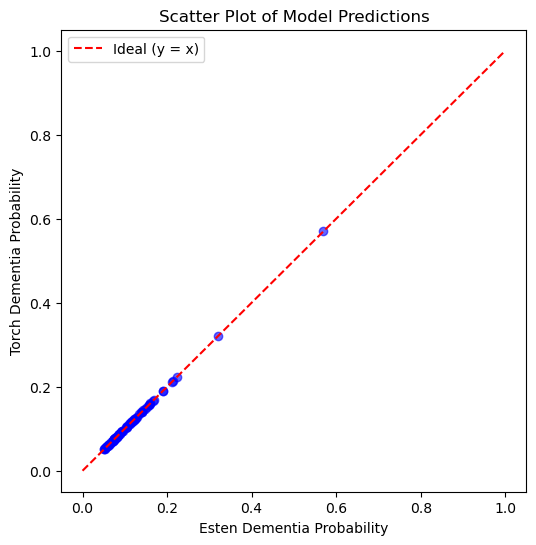

In [13]:
import matplotlib.pyplot as plt

# Ensure the dictionaries have the same subjects
predictions_leo_dict = {pred['subject']: pred['dementia_prob'] for pred in predictions_leo}
predictions_torch_dict = {pred['subject']: pred['dementia_prob'] for pred in predictions_torch}

subjects = [subj for subj in predictions_leo_dict.keys()]

predictions_torch_dict = {key: value for key, value in predictions_torch_dict.items() if key in subjects}

plt.figure(figsize=(6, 6))
plt.scatter(predictions_leo_dict.values(), predictions_torch_dict.values(), color='blue', alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y = x)')
plt.xlabel('Esten Dementia Probability')
plt.ylabel('Torch Dementia Probability')
plt.title('Scatter Plot of Model Predictions')
plt.legend()
plt.show()